In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import sys
sys.path.append("../") # path to ssgp root directory

In [3]:
import ssgp

In [4]:
def plot_pred(model,X_test,n_std = 1,plot_data=True):
    if plot_data and model.X is not None:
        plt.plot(model.X.numpy(),model.Y.numpy(),'k+',ms=10,label="observations")
        plt.plot(model.X.numpy()[-1],model.Y.numpy()[-1],'r+',ms=10,mew=2)
    mean_test, var_test = model.predict(X_test)
    plt.plot(X_test.numpy(),mean_test.numpy(),'b-',label="GP")
    stddev_test = np.sqrt(var_test.numpy().diagonal())
    plt.fill_between(X_test.numpy().ravel(),mean_test.numpy().ravel()-n_std*stddev_test,mean_test.numpy().ravel()+n_std*stddev_test,alpha=0.2)

In [5]:
def example_function(x):
    return torch.norm(x,dim=1)**2

In [13]:
dim = 1
n_freqs = 100
model = ssgp.models.ISSGPR(n_freqs,dim,
                           noise_stddev=0.1,
                           signal_stddev=5.)

In [14]:
n_train = 20
X = torch.randn(n_train,dim)
y = example_function(X)[:,None]
model.set_data(X,y)

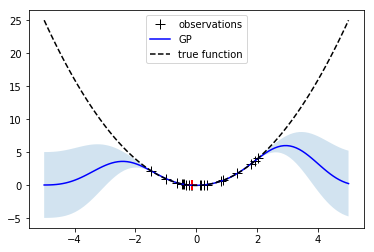

In [18]:
n_test = 100
Xq = torch.linspace(-5,5,n_test)[:,None]
plot_pred(model,Xq)
plt.plot(Xq.numpy(),example_function(Xq).numpy(),'k--',label="true function")
plt.legend()